# Effect of Various Gasses on Temperature

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import os, warnings
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#import country temperature data and gas data
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
co2 = pd.read_csv('../data/CO2emissions/co2.csv')
methane = pd.read_csv('../data/methane/methane.csv')
no2 = pd.read_csv('../data/no2/no2.csv')

In [3]:
#the gas data requires a lot of cleaning to get into a form similar to the temp data
#takes in gas data set and produces a dataframe with a format similar to the temp dataframes
def cleanData(df):
    data = []
    for each in df.values:
        info = each[0].split('\t')
        data.append(info)
    boo = DataFrame(data=data,columns= co2.columns.values[0].split('\t'))
    del boo['Country Code']
    del boo['Indicator Name']
    del boo['Indicator Code']
    dataset = DataFrame()
    countries = boo['Country Name'].unique()
    for country in countries:
        holder=boo[boo['Country Name']==country]
        for each in holder.columns[1:]:
            zoo=DataFrame()
            zoo['Country'] = holder['Country Name']
            zoo['Year'] = each
            zoo['Emissions'] = holder[each]
            dataset = dataset.append(zoo)
    dataset['Emissions'] = dataset['Emissions'].apply(lambda x:None if x=='' else float(x))
    dataset = dataset.dropna().reset_index(drop=True)
    return(dataset)

In [4]:
#clean all the gas data and convert the values of methane and NO2 to metric tons of CO2
#finally, merge into one dataframe
codata = cleanData(co2) #metric tons
codata.rename(columns={'Emissions':'CO2 Emissions'},inplace=True)
medata = cleanData(methane) #kt of CO2 equivalent
medata['Emissions'] = medata['Emissions'].apply(lambda x:x*1000)
medata.rename(columns={'Emissions':'Methane Emissions'},inplace=True)
nodata = cleanData(no2) #kt of CO2 equivalent
nodata['Emissions'] = nodata['Emissions'].apply(lambda x:x*1000)
nodata.rename(columns={'Emissions':'NO2 Emissions'},inplace=True)
gasData = pd.merge(codata,medata,on=['Country','Year'],how='outer')
gasData = pd.merge(gasData,nodata,on=['Country','Year'],how='outer')
# gasData.head()

In [5]:
#takes in country and plots the gas data for it
def plotGases(zoo):
    holder = gasData[gasData['Country'] == zoo]
    plt.figure(figsize=(6.5,4))
    host = host_subplot(111, axes_class=AA.Axes)
    ax = host.twinx()
    ax2 = host.twinx()
    
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis['right'] = new_fixed_axis(loc='right',axes=ax2,offset=(55,0))

    co=host.plot(holder['Year'],holder['CO2 Emissions'], label='CO2')
    me=ax.plot(holder['Year'],holder['Methane Emissions'], label='Methane')
    no=ax2.plot(holder['Year'],holder['NO2 Emissions'], label='NO2')
    
    host.set_title('Gas Emissions of '+zoo+' (Metric Tons of C02)')
    host.set_ylabel('CO2 Emissions')
    ax.set_ylabel('Methane Emissions')
    ax2.set_ylabel('NO2 Emissions')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    host.set_xlim(1970,2013)
    host.legend()


In [6]:
#Remove unwanted data
countryTemp = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Australia','Antarcita']
#Remove continents from country temp
countryTemp = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTemp = countryTemp[~countryTemp['Country'].str.contains('(Europe)')]
countryTemp = countryTemp.dropna()
countryTemp['dt'] = pd.to_datetime(countryTemp['dt'])
countryTemp['Year'] = countryTemp['dt'].apply(lambda x : x.strftime('%Y'))
yearTemp = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)


In [7]:
#Highest temperature deltas between 1970 and 2013
tempTemp = yearTemp[yearTemp['Year'] > '1970']
tempTemp = tempTemp[tempTemp['AverageTemperatureUncertainty'] < 1.5]
countries = tempTemp['Country'].unique()
listHolder = []
for each in countries:
    holder = tempTemp[tempTemp['Country'] == each]
    holder.sort_values('Year')
    oldTemp = holder['AverageTemperature'].head(5).mean()
    minYear = holder['Year'].iloc[0]
    newTemp = holder['AverageTemperature'].tail(5).mean()
    diffTemp = newTemp - oldTemp
    listHolder.append((each,minYear,oldTemp,newTemp,diffTemp))
    
diffs = DataFrame(listHolder, columns=('Country',
                                       'FirstYear',
                                       'OldTemp',
                                       'NewTemp',
                                       'DiffTemp')).sort_values(by='DiffTemp', ascending=False).reset_index(drop=True)

# diffs.head(6)


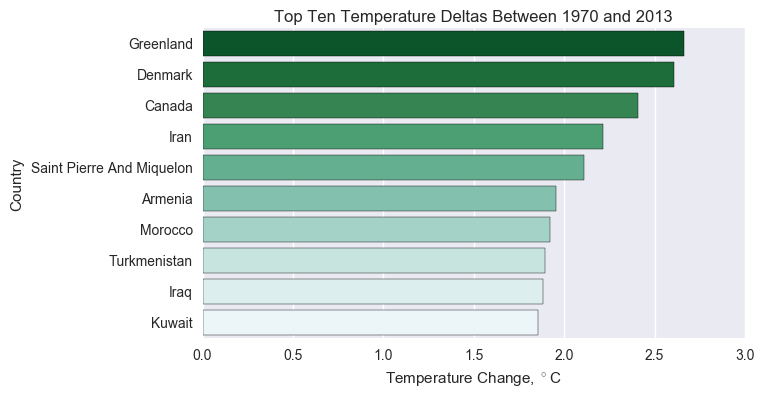

In [8]:
#print ten hightest temperature deltas
plt.figure(figsize=(7,4))
ax = sns.barplot(diffs['DiffTemp'][0:10],diffs['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Top Ten Temperature Deltas Between 1970 and 2013')
plt.savefig("./ana_4/topSixDiffs.png", bbox_inches='tight',dpi=600)

In [9]:
#take in a list of countries and output the data in a dataframe with average temp and temp +/- uncertainty
def plotData(zoo):
    data = DataFrame()
    avgHolder = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)
    for each in zoo:
        holderTemp = avgHolder[avgHolder['Country'] == each]
        holderTemp = holderTemp[holderTemp['Year'] >= '1970']
        holderAvg = holderTemp['AverageTemperature'].mean()
        holderTemp['AverageTemperature'] = holderTemp['AverageTemperature'].apply(lambda x : x - holderAvg)

        holderTemp['AverageTemperature'] = savgol_filter(holderTemp['AverageTemperature'], 3, 1)

        holderTemp['Upper'] = holderTemp['AverageTemperature'] + holderTemp['AverageTemperatureUncertainty']
        holderTemp['Lower'] = holderTemp['AverageTemperature'] - holderTemp['AverageTemperatureUncertainty']

        holderT = holderTemp[['Country']+['Year']+['AverageTemperature']]
        holderT.columns = ['Country','Year','AvgTemp']
        holderT['Count'] = 0
        holderU = holderTemp[['Country']+['Year']+['Upper']]
        holderU.columns = ['Country','Year','AvgTemp']
        holderU['Count'] = 1
        holderL = holderTemp[['Country']+['Year']+['Lower']]
        holderL.columns = ['Country','Year','AvgTemp']
        holderL['Count'] = 2

        name = each.replace(" ","")
        name = 'all'+name

        name = holderT.append(holderU)
        name = name.append(holderL).sort_values('Year').reset_index(drop=True)

        data = data.append(name)
    return data

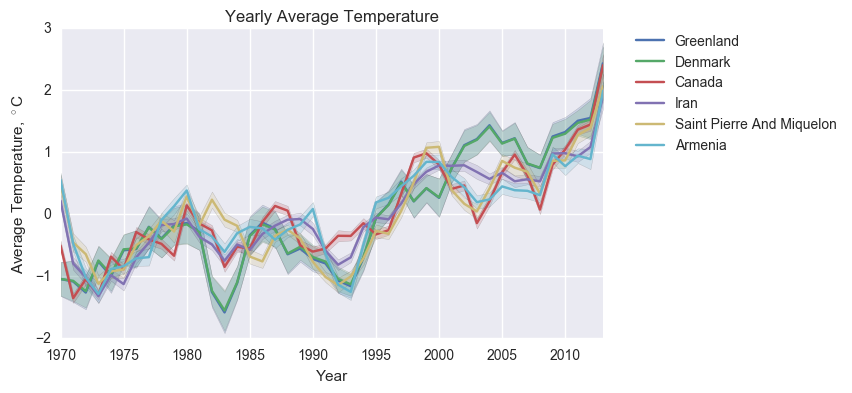

In [10]:
#plot comparison of 6 countries with highest delta
plt.figure(figsize=(7,4))
stuff = plotData(diffs['Country'].unique()[:6])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/maxDiffs.png", bbox_inches='tight',dpi=600)

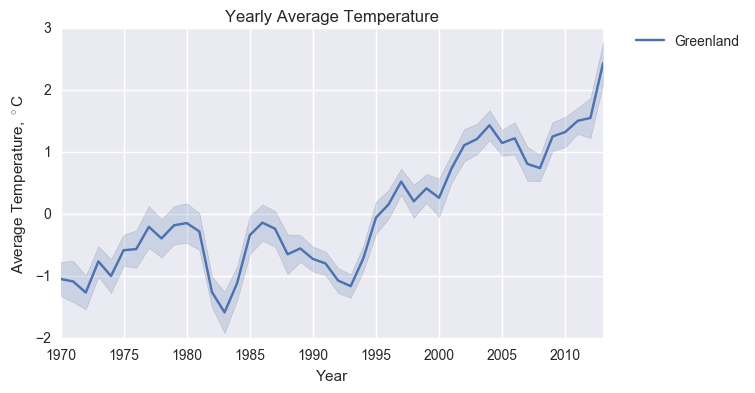

In [11]:
#plot Greenland temp data
plt.figure(figsize=(7,4))
stuff = plotData(['Greenland'])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/GreenlandTemp.png", bbox_inches='tight',dpi=600)

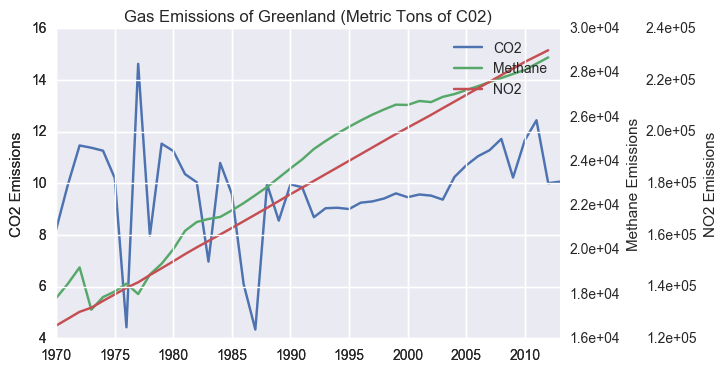

In [12]:
#plot Greenland gas data
plotGases('Greenland')
plt.savefig("./ana_4/GreenlandGases.png", bbox_inches='tight',dpi=600)

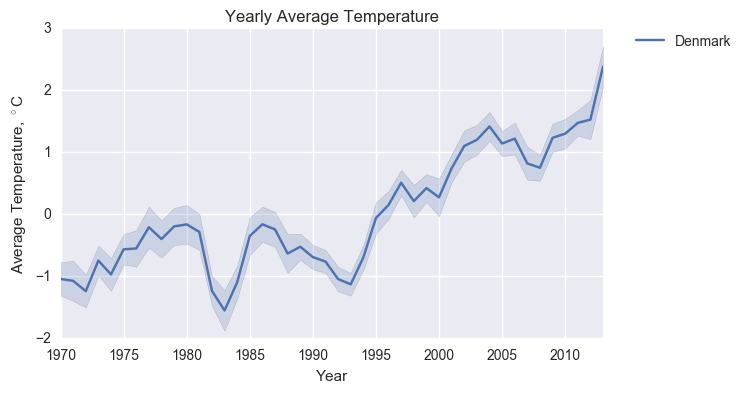

In [13]:
#plot Denmark temp data
plt.figure(figsize=(7,4))
stuff = plotData(['Denmark'])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/DenmarkTemp.png", bbox_inches='tight',dpi=600)

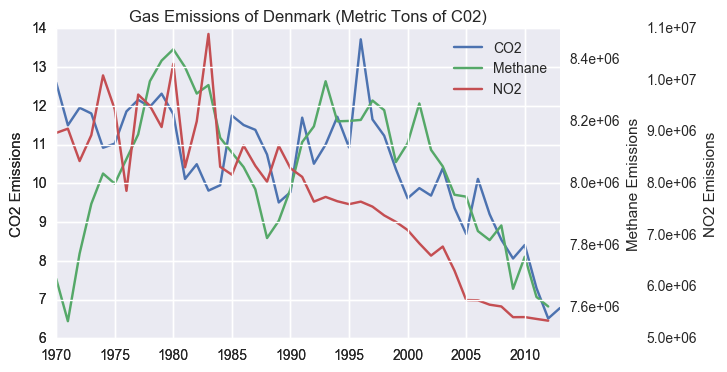

In [14]:
#plot Denmark gas data
plotGases('Denmark')
plt.savefig("./ana_4/DenmarkGases.png", bbox_inches='tight',dpi=600)

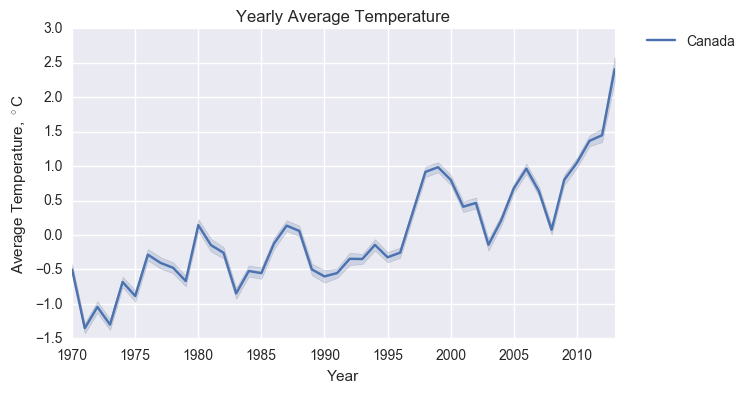

In [15]:
#plot Canada temp data
plt.figure(figsize=(7,4))
stuff = plotData(['Canada'])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/CanadaTemp.png", bbox_inches='tight',dpi=600)

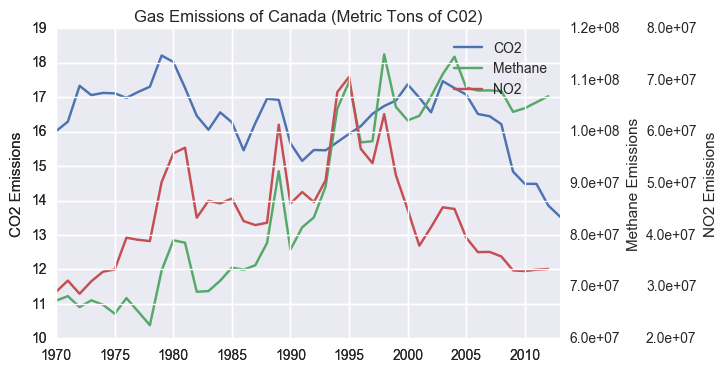

In [16]:
#plot Canada gas data
plotGases('Canada')
plt.savefig("./ana_4/CanadaGases.png", bbox_inches='tight',dpi=600)

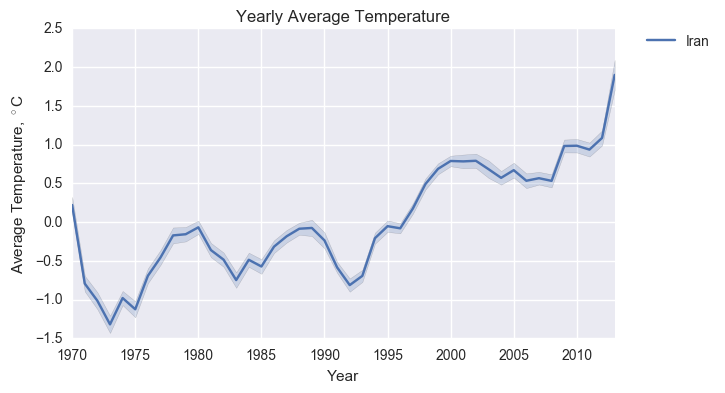

In [17]:
#plot Iran temp data
plt.figure(figsize=(7,4))
stuff = plotData(['Iran'])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/IranTemp.png", bbox_inches='tight',dpi=600)

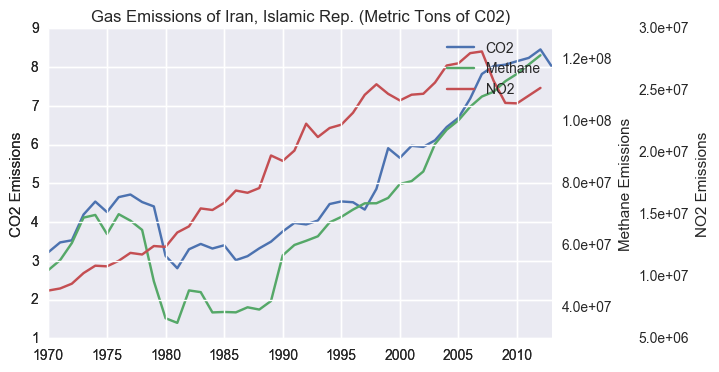

In [18]:
#plot Iran gas data
plotGases('Iran, Islamic Rep.')
plt.savefig("./ana_4/IranGases.png", bbox_inches='tight',dpi=600)

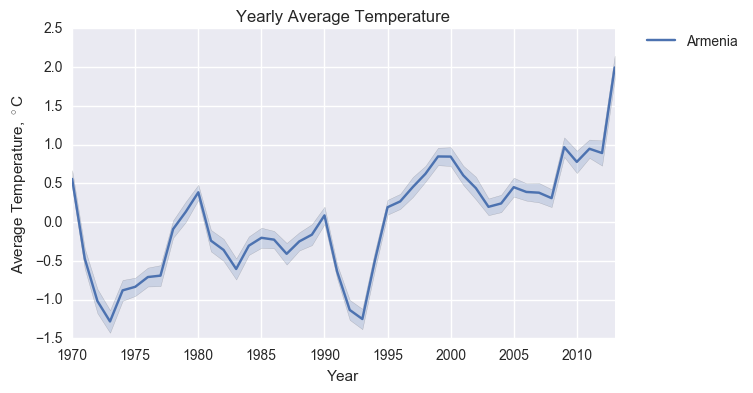

In [19]:
#Plot Armenia temp data
plt.figure(figsize=(7,4))
stuff = plotData(['Armenia'])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim([1960,2020])
plt.savefig("./ana_4/ArmeniaTemp.png", bbox_inches='tight',dpi=600)

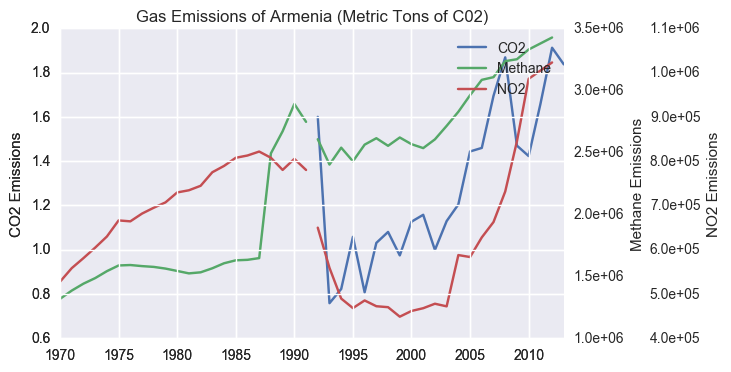

In [20]:
#plot Armenia gas data
plotGases('Armenia')
plt.savefig("./ana_4/ArmeniaGases.png", bbox_inches='tight',dpi=600)